## Which is higher: 4 out of 10, or 300 out of 1000?

Obviously 0.4 is greater than 0.3, but if you are evaluating two basketball players: the first one got 300 2-pointer goals out of 1000 attempts, and the second one is pretty new and he got 4 2-pointer goals out of 10. 

It's difficult to measure the performance of these two players, because the first player has a proportion of goals but it's not a lot of evidence. Therefore, we will use empirical Bayes estimation to estimate their 2-pointer-goal average.

Empirical Bayes estimation, where a beta distribution fit on all observations is then used to improve each individually.

What's great about this method is that as long as we have a lot of examples, we don't need to bring in prior expectations.

This is notebook we will use the [nba-players-stats dataset from kaggle](https://www.kaggle.com/drgilermo/nba-players-stats) to estimate the prior expectation.

## Dataset Setup

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'

In [3]:
df_nba = pd.read_csv(project_dir + '/data/nba-players-stats/Seasons_Stats.csv')

In [4]:
df_nba.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [5]:
# We will select all players in position PG and there 
df_pg = df_nba \
    .loc[:, ['Year', 'Player', 'Pos', '2P', '2PA']] \
    .where(df_nba.loc[:,'Pos']=='PG') \
    .dropna()
# Create 2P%: Two Point Field Goal Percentage
df_pg['2P%'] = df_pg.loc[:, '2P'] / df_pg.loc[:, '2PA']
df_pg.loc[:,'2P%'].fillna(0, inplace = True)
df_pg

,Year,Player,Pos,2P,2PA,2P%
11,1950.0,Nelson Bobb,PG,80.0,248.0,0.322581
32,1950.0,Al Cervi*,PG,143.0,431.0,0.331787
49,1950.0,Bob Davies*,PG,317.0,887.0,0.357384
108,1950.0,Red Holzman*,PG,206.0,625.0,0.329600
114,1950.0,Ralph Johnson,PG,243.0,779.0,0.311938
...,...,...,...,...,...,...
24661,2017.0,Deron Williams,PG,178.0,366.0,0.486339
24662,2017.0,Deron Williams,PG,132.0,272.0,0.485294
24663,2017.0,Deron Williams,PG,46.0,94.0,0.489362
24681,2017.0,Delon Wright,PG,39.0,86.0,0.453488


In [6]:
# Let's see who is the best and who is the worst.
df_pg.sort_values('2P%',ascending = False).head()

,Year,Player,Pos,2P,2PA,2P%
10508,1992.0,Myron Brown,PG,3.0,3.0,1.0
15165,2001.0,Jason Hart,PG,1.0,1.0,1.0
12266,1995.0,Morlon Wiley,PG,2.0,2.0,1.0
21249,2012.0,Justin Dentmon,PG,2.0,2.0,1.0
24065,2016.0,Briante Weber,PG,1.0,1.0,1.0


In [7]:
df_pg.sort_values('2P%').head()

,Year,Player,Pos,2P,2PA,2P%
9771,1990.0,Jim Les,PG,0.0,0.0,0.0
8985,1988.0,Walker Russell,PG,0.0,0.0,0.0
8928,1988.0,Johnny Moore,PG,0.0,1.0,0.0
9965,1990.0,Mark Wade,PG,0.0,0.0,0.0
19631,2009.0,Damon Jones,PG,0.0,6.0,0.0


Apparently, the 2-pointer-goal average is a ineffectual measurement.

In [8]:
# Exclude 0 and 1 to fit a beta distribution later
df_b = df_pg[(df_pg.loc[:,'2P%']<1) & (df_pg.loc[:,'2P%']>0)]
df_b['bin'] = pd.cut(df_b.loc[:,'2P%'], bins=np.linspace(0, 1, 50), include_lowest=True)
df_b

/home/rick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Player,Pos,2P,2PA,2P%,bin
11,1950.0,Nelson Bobb,PG,80.0,248.0,0.322581,"(0.306, 0.327]"
32,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,"(0.327, 0.347]"
49,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,"(0.347, 0.367]"
108,1950.0,Red Holzman*,PG,206.0,625.0,0.329600,"(0.327, 0.347]"
114,1950.0,Ralph Johnson,PG,243.0,779.0,0.311938,"(0.306, 0.327]"
...,...,...,...,...,...,...,...
24661,2017.0,Deron Williams,PG,178.0,366.0,0.486339,"(0.469, 0.49]"
24662,2017.0,Deron Williams,PG,132.0,272.0,0.485294,"(0.469, 0.49]"
24663,2017.0,Deron Williams,PG,46.0,94.0,0.489362,"(0.469, 0.49]"
24681,2017.0,Delon Wright,PG,39.0,86.0,0.453488,"(0.449, 0.469]"


## Estimate a prior from the data

### Draw a graph of the distribution of 2P averages across players.

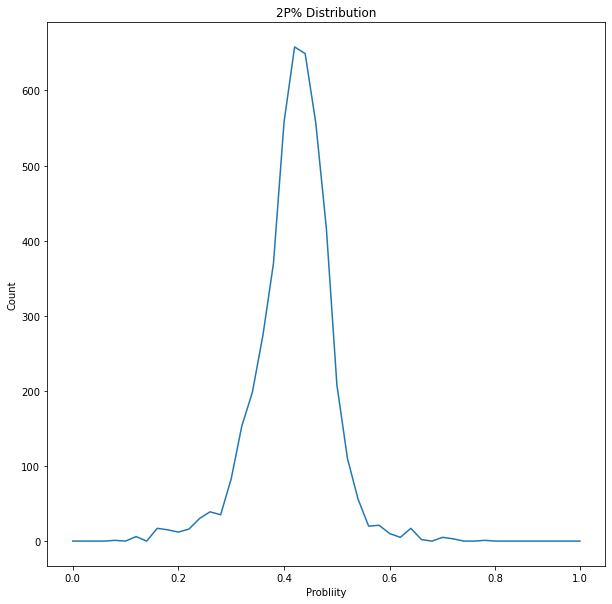

In [9]:

fig, ax = plt.subplots(figsize = (10, 10))
df_temp = df_b \
    .groupby('bin') \
    .count() \
    .loc[:, 'Player']

df_temp.plot(kind = 'line',
          figsize = (10, 10),
          ax = ax,
          title = '2P% Distribution')

# positions of each tick, relative to the indices of the x-values
pos = list(range(0, df_temp.size, 10)) + [df_temp.size-1]
ax.set_xticks(pos)

# labels
ax.set_xticklabels([round(n,2) for n in np.linspace(0, 1, len(pos))])
plt.ylabel('Count')
plt.xlabel('Probliity')
plt.show()

### Calculate the a and b

We need to calculate the a and b for our bete(a, b) distribution.

In [10]:
df_b.loc[:,'2P%']

11       0.322581
32       0.331787
49       0.357384
108      0.329600
114      0.311938
           ...   
24661    0.486339
24662    0.485294
24663    0.489362
24681    0.453488
24683    0.428571
Name: 2P%, Length: 4546, dtype: float64

In [11]:
beta_fit = beta.fit(data = df_b.loc[:,'2P%'], floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')

a: 20.52,b: 26.41


### Calculate each estimate based on beta distribution



In [12]:
df_pg.sort_values('2P%').head()

,Year,Player,Pos,2P,2PA,2P%
9771,1990.0,Jim Les,PG,0.0,0.0,0.0
8985,1988.0,Walker Russell,PG,0.0,0.0,0.0
8928,1988.0,Johnny Moore,PG,0.0,1.0,0.0
9965,1990.0,Mark Wade,PG,0.0,0.0,0.0
19631,2009.0,Damon Jones,PG,0.0,6.0,0.0


Now we can calculate individual 2P% based on beta distribution(prior). For example the player Johnny Moore, his 2P% is 20.52/(20.52+26.41+1) = 0.428. With the updated 2P%, we can compare him with other players.

In [13]:
# Calculate individual estimate

df_pg['2P%_estimate'] = df_pg.apply(lambda x: (x['2P']+a)/(a+b+x['2PA']), axis = 1)
df_pg

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
11,1950.0,Nelson Bobb,PG,80.0,248.0,0.322581,0.340827
32,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.342142
49,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361398
108,1950.0,Red Holzman*,PG,206.0,625.0,0.329600,0.337118
114,1950.0,Ralph Johnson,PG,243.0,779.0,0.311938,0.319059
...,...,...,...,...,...,...,...
24661,2017.0,Deron Williams,PG,178.0,366.0,0.486339,0.480759
24662,2017.0,Deron Williams,PG,132.0,272.0,0.485294,0.478224
24663,2017.0,Deron Williams,PG,46.0,94.0,0.489362,0.472007
24681,2017.0,Delon Wright,PG,39.0,86.0,0.453488,0.447754


In [14]:
# Now let's see who is the best and who is the worst
df_pg.sort_values('2P%_estimate',ascending = False).head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
4959,1977.0,Dave Twardzik,PG,263.0,430.0,0.611628,0.594469
9018,1988.0,John Stockton*,PG,430.0,724.0,0.593923,0.584385
6896,1983.0,Brad Davis,PG,348.0,585.0,0.594872,0.583166
13103,1997.0,Steve Kerr,PG,139.0,230.0,0.604348,0.576030
13337,1997.0,John Stockton*,PG,340.0,579.0,0.587219,0.575975


In [15]:
df_pg.sort_values('2P%_estimate').head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
125,1950.0,Walt Kirk,PG,97.0,361.0,0.268698,0.288089
1299,1958.0,Brendan McCann,PG,22.0,100.0,0.220000,0.289390
537,1952.0,Red Holzman*,PG,104.0,372.0,0.279570,0.297233
675,1953.0,Red Holzman*,PG,38.0,149.0,0.255034,0.298678
126,1950.0,Walt Kirk,PG,31.0,125.0,0.248000,0.299657


Lastly, let's answer our question: Which player is better: the player with 4 goals out of 10, or the player with 300 goals out of 1000.

In [16]:
print(f'2P% _estimate for the first player is (4+a)/(10+a+b)={round((4+a)/(10+a+b),2)}')
print(f'2P% _estimate for the first player is (300+a)/(1000+a+b)={round((300+a)/(1000+a+b),2)}')

2P% _estimate for the first player is (4+a)/(10+a+b)=0.43
2P% _estimate for the first player is (300+a)/(1000+a+b)=0.31


Based on the evidence given, the player one will be our choice.